# FV Shear estimation

In [5]:
# %
# % Test for shear modulus estimation using inner displacements
# %
# % We consider the simplified elasticity model for a given displacement
# % field 'u' :
# %
# % -rho*w^2*u - div(G*grad(u)) = 0   at each voxel
# %
# % Then, after integration over each voxel and, assuming that
# % G is piecewise constant and rho=1 [gr/cm^3], we obtain the vectorial
# % system for each G(voxel) as follows:
# % 
# % G = -rho*w^2 * dot(b,p)/dot(b,b)  at each voxel
# %
# % where
# %
# % b = int_{voxel boundary} e(u)*nds   (integration on the surface)
# % p = int_{voxel} u dx                (integration in the voxel)
# %  
# % with e(u) = 1/2 (grad(u) + grad(u)^T) is the linear strain tensor.
# %
# %
# % Joaquin Mura (2017)
# %

import scipy.io as sio
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

# some physical parameters
dx  = 1e-3; # 1 mm
dy  = 1e-3;
dz  = 1e-3;
rho = 1e+3; # 1 g/cm^3

# Color axis limits
Gmin = 2.5e3; #  2.5 KPa
Gmax = 1.05e4;# 10.5 KPa

# simulated frequencies: 50Hz, 60Hz, 70Hz and 80Hz
freq = [50,60,70,80];

mat_contents = sio.loadmat('../data/synthetic/square/sim.mat')
U = mat_contents['U']

In [6]:
def show_images(Uc,i,n):
    for k in range(0,n):
        plt.title("Slice " + str(k))
        plt.imshow(abs(Uc[:,:,k,i,0]))
        plt.colorbar()
        plt.show()

'''
function Du = DUdxdy(u,[dx,dy,dz],i,j,k)

Evaluate local term for int_(front-back) du/dx_i dxdy

matrix 'u' is an NxMxL array built using meshgrid
'''
def DUdxdy(u,D,i,j,k):
    Du = [0,0,0]
    Du[0] = 0.25*D[1]*(u[i-1,j,k+1] + u[i+1,j,k-1] - u[i+1,j,k+1] - u[i-1,j,k-1])
    Du[1] = 0.25*D[0]*(u[i,j-1,k+1] + u[i,j+1,k-1] - u[i,j-1,k-1] - u[i,j+1,k+1])
    Du[2] = D[0]*D[1]/D[2]*(u[i,j,k+1] - 2*u[i,j,k] + u[i,j,k-1])
    return Du

   
'''
function Du = DUdxdz(u,[dx,dy,dz],i,j,k)

Evaluate local term for int_(north-south) du/dx_i dxdz

matrix 'u' is an NxMxL array built using meshgrid
'''
def DUdxdz(u,D,i,j,k):
    Du = [0,0,0]
    Du[0] = 0.25*D[2]*(u[i-1,j+1,k] + u[i+1,j-1,k] - u[i+1,j+1,k] - u[i-1,j-1,k])
    Du[1] = D[0]*D[2]/D[1]*(u[i,j+1,k] - 2*u[i,j,k] + u[i,j-1,k])
    Du[2] = 0.25*D[0]*(u[i,j-1,k+1] + u[i,j+1,k-1] - u[i,j-1,k-1] - u[i,j+1,k+1])
    return Du


'''
function Du = DUdydz(u,[dx,dy,dz],i,j,k)

 Evaluate local term for int_(east-west) du/dx_i dydz

 matrix 'u' is an NxMxL array built using meshgrid
'''
def DUdydz(u,D,i,j,k):

    Du = [0,0,0]
    Du[0] = (D[1]*D[2]/D[0])*( u[i+1,j,k] - 2*u[i,j,k] + u[i-1,j,k] )
    Du[1] = 0.25*D[2]*(u[i+1,j+1,k] - u[i+1,j-1,k] - u[i-1,j+1,k] + u[i-1,j-1,k])
    Du[2] = 0.25*D[1]*(u[i+1,j,k+1] - u[i+1,j,k-1] - u[i-1,j,k+1] + u[i-1,j,k-1])
    return Du

In [7]:
# The data is 6D: y, x, z, time steps, encoding direction, frequency
[ny,nx,nz,nt,_nenc,nf]  = U.shape


In [8]:
U_fft = fft(U,axis=3)
Uc    = np.squeeze(U_fft[:,:,:,1,:,:]);

In [31]:
f = 0
# Ux = squeeze(Uc(:,:,:,2,:));
# Uy = squeeze(Uc(:,:,:,1,:));
# Uz = squeeze(Uc(:,:,:,3,:));
Ux = Uc[:,:,:,1,f]
Uy = Uc[:,:,:,0,f]
Uz = Uc[:,:,:,2,f]
G = np.zeros(shape=[nx,ny,nz])
for i in range(1,nx-1):
    for j in range(1,ny-1):
        for k in range(1,nz-1):
            volume = dx*dy*dz
            p = [Ux[i,j,k]*volume, Uy[i,j,k]*volume, Uz[i,j,k]*volume]
            dV = [dx,dy,dz]
            Uxxy = DUdxdy(Ux,dV,i,j,k)
            Uyxy = DUdxdy(Uy,dV,i,j,k)
            Uzxy = DUdxdy(Uz,dV,i,j,k)
            Uxxz = DUdxdz(Ux,dV,i,j,k)
            Uyxz = DUdxdz(Uy,dV,i,j,k)
            Uzxz = DUdxdz(Uz,dV,i,j,k)
            Uxyz = DUdydz(Ux,dV,i,j,k)
            Uyyz = DUdydz(Uy,dV,i,j,k)
            Uzyz = DUdydz(Uz,dV,i,j,k)
            bx = [Uxyz[0], 0.5*(Uxyz[1]+Uyyz[0]), 0.5*(Uxyz[2]+Uzyz[0])]
            by = [0.5*(Uxxz[1]+Uyxz[0]), Uyxz[1], 0.5*(Uyxz[2]+Uzxz[1])]
            bz = [0.5*(Uxxy[2]+Uzxy[0]), 0.5*(Uyxy[2]+Uzxy[1]), Uzxy[2]]
            b = [bx[n] + by[n] + bz[n] for n in range(0,3)]
            
            # Evaluation of shear modulus
            G[i,j,k] =-rho*(2*np.pi*freq[f])**2/abs(np.vdot(b,b))*abs(np.vdot(b,p))
            print(abs(np.vdot(b,b)),abs(np.vdot(b,p)),abs(np.vdot(p,p)))
            
            

            


1.0372739272800706e-08 5.731956163508091e-13 3.167678772853592e-17
1.0429259208157164e-08 5.762940535898557e-13 3.184464688497294e-17
1.0414589751452145e-08 5.750511973767109e-13 3.1753040027616343e-17
1.0101394588446276e-08 5.478370363448868e-13 2.9712258774257e-17
1.0168435742758741e-08 5.511166365473774e-13 2.9869890663666344e-17
1.0133011906877917e-08 5.493704594873662e-13 2.978520609000698e-17
9.008630802917618e-09 4.899448944396965e-13 2.664848641592329e-17
9.053428876892269e-09 4.924803625990493e-13 2.6789621511204197e-17
9.038232354003639e-09 4.91377782571551e-13 2.671605270712964e-17
7.713528788345143e-09 4.192763705907918e-13 2.279359109569897e-17
7.75872401448997e-09 4.2164143404774705e-13 2.291392991256367e-17
7.729240716044682e-09 4.2026471263971054e-13 2.285368984900576e-17
6.1693410129863675e-09 3.380275489247072e-13 1.8526061167326258e-17
6.1982744495124135e-09 3.3974583487717195e-13 1.8622685559369834e-17
6.188336801421561e-09 3.3902371629404334e-13 1.857706124994153e-

1.1008835224811967e-08 5.94032671368896e-13 3.205550406078079e-17
1.09824785623521e-08 5.918540155174705e-13 3.1901707217364726e-17
1.1058633429580467e-08 5.978397528483801e-13 3.2320731235403415e-17
1.110391461924129e-08 5.995375112423165e-13 3.237225123824143e-17
1.1023539493209164e-08 5.958543899416464e-13 3.2214442455408274e-17
1.0872220653251569e-08 5.814365707947186e-13 3.109513436361526e-17
1.0891674601700575e-08 5.823849167300917e-13 3.114159936895042e-17
1.0850848999314316e-08 5.798193726201957e-13 3.098827731675128e-17
1.0147000659043638e-08 5.375055004482062e-13 2.847367811958734e-17
1.0174730579040172e-08 5.385773342272609e-13 2.8509506385215433e-17
1.0118890573466985e-08 5.357077080466369e-13 2.836707901785008e-17
7.806710997762452e-09 4.3984669571931413e-13 2.4783817480550803e-17
7.812973400658022e-09 4.402092510824292e-13 2.4804324914383923e-17
7.767612382808756e-09 4.3777238651246977e-13 2.4678762413400756e-17
6.640923834125787e-09 3.6923824890527755e-13 2.0538682518581

7.737861676702896e-10 4.3613943260998657e-14 2.4642960269776452e-18
7.6989236407452e-10 4.339061459621594e-14 2.4465252847322977e-18
7.709145138519157e-10 4.33967088037281e-14 2.4487398312085908e-18
1.3552380299374954e-09 4.9983150561176866e-14 1.8493624814477535e-18
1.3450463338016654e-09 4.9579645017063146e-14 1.828806172346621e-18
1.346426244987446e-09 4.953790233334809e-14 1.8324059156674475e-18
9.597273499341047e-10 4.790983378559667e-14 2.3967634032919234e-18
9.55785003680007e-10 4.7677203315704776e-14 2.3791162672705403e-18
9.546065556874021e-10 4.7571701075387135e-14 2.378217072883082e-18
2.542653346956483e-09 1.0340932637499666e-13 4.222268324472402e-18
2.5526585506189777e-09 1.0370850193496704e-13 4.213940158890727e-18
2.5397196879195577e-09 1.0308456314919897e-13 4.202390324002348e-18
4.806121587031152e-09 1.8637075538016478e-13 7.233699340068062e-18
4.822478237692618e-09 1.868521955188967e-13 7.240480848352958e-18
4.798552549133846e-09 1.8593594810408063e-13 7.2129887496434

9.885265208947041e-09 5.261205469238198e-13 2.800297701462119e-17
1.4701477722006006e-08 6.593172382303414e-13 2.957379824798335e-17
1.4811429830631922e-08 6.633597972075768e-13 2.9711276059979035e-17
1.475915268483059e-08 6.607347309434174e-13 2.958026846559883e-17
1.5728573666421337e-08 6.782170625397305e-13 2.925276528993116e-17
1.5792514084642194e-08 6.812732142654676e-13 2.939106883605087e-17
1.5634801466199182e-08 6.76402033832577e-13 2.9263395043764566e-17
6.990418998655949e-09 4.3389331835733334e-13 2.6949348551105436e-17
7.039715642401862e-09 4.365943200321307e-13 2.7079394662954207e-17
7.021869714263947e-09 4.351067086657858e-13 2.6966264164702244e-17
4.744721483616412e-09 3.323560536351129e-13 2.331208361658603e-17
4.766485535706994e-09 3.341388889787805e-13 2.3425937260492305e-17
4.751244049385592e-09 3.328815949542512e-13 2.333295704035669e-17
7.702850338898468e-09 3.7999217721707287e-13 1.876673526746361e-17
7.731179116978955e-09 3.8180075090791673e-13 1.8857778567986236e

3.473114476445874e-09 1.4740520598633298e-13 6.258588851721125e-18
3.454678182106957e-09 1.467175259525235e-13 6.242398252904522e-18
3.997403586770488e-09 2.0275335386736773e-13 1.028777375189327e-17
3.99006898594501e-09 2.0217625004707393e-13 1.0244938460862278e-17
3.969662686337961e-09 2.0118710541207558e-13 1.0205933177795484e-17
7.680334904796484e-09 3.424899604814027e-13 1.5279573973495346e-17
7.692422044199126e-09 3.4247996514104184e-13 1.5248962646593357e-17
7.641339829298168e-09 3.405095732743116e-13 1.5182169660068627e-17
7.80615483751865e-09 3.9864954156687787e-13 2.0363685639755435e-17
7.801933507498528e-09 3.984532372012639e-13 2.03500354947423e-17
7.776561196577758e-09 3.9677352251207826e-13 2.025574187411701e-17
1.004827875013759e-08 5.016036950093559e-13 2.5049224369908956e-17
1.0051325598956389e-08 5.018194076102149e-13 2.5054922257814586e-17
1.002103392050074e-08 4.997832119853918e-13 2.493548879905993e-17
1.000348175475355e-08 5.354064111980826e-13 2.866247235138101e-

3.967630065689092e-09 2.6379189929179907e-13 1.7545431530062877e-17
3.9765384488561274e-09 2.642046827591854e-13 1.7558024528688677e-17
3.945250158618693e-09 2.6249315405805683e-13 1.7467138540163752e-17
5.787495328480213e-09 2.70175490007462e-13 1.261370230828548e-17
5.792356662989501e-09 2.702303425893792e-13 1.260866174366188e-17
5.760541414578117e-09 2.687457081520396e-13 1.2544883333480752e-17
2.2768795962838063e-09 1.3532351408005056e-13 8.045923463393413e-18
2.2718662459925978e-09 1.3500558965934378e-13 8.025150081759725e-18
2.2532949247108947e-09 1.3409554917098712e-13 7.988922318557748e-18
1.4668939889399745e-09 8.094674506169666e-14 4.472768968680926e-18
1.4522518255226996e-09 8.028830703390917e-14 4.4413954846715975e-18
1.4468663608046527e-09 7.999975372237302e-14 4.430735295145657e-18
2.5693020945380152e-09 7.585147406978582e-14 2.2456225906242202e-18
2.5595403637495373e-09 7.520413163524786e-14 2.2111455170646775e-18
2.5430206391876848e-09 7.496440342635298e-14 2.222363416

9.712687193321473e-09 4.657710498948026e-13 2.233793056217257e-17
9.763075683318443e-09 4.672557330063784e-13 2.2369183062772522e-17
1.5072466544146145e-08 6.455080142430024e-13 2.77070225758826e-17
1.5127286191768536e-08 6.49324820003495e-13 2.788027597795198e-17
1.517408223455148e-08 6.502498474157271e-13 2.7900541058621367e-17
9.458861934425007e-09 5.525476765714425e-13 3.228403205804013e-17
9.507601711096243e-09 5.557354435709305e-13 3.2484441384719e-17
9.584912903900509e-09 5.579324505591923e-13 3.249549901986569e-17
1.1890626986442828e-08 6.524608473760003e-13 3.580397915471231e-17
1.1969002736972722e-08 6.565723892513457e-13 3.602192706607617e-17
1.1897726238058142e-08 6.546319636884552e-13 3.6023886759222965e-17
1.511416502969258e-08 7.560497718591884e-13 3.794886215858199e-17
1.532201173473807e-08 7.647106144850021e-13 3.8171477881840305e-17
1.5276335866602173e-08 7.63056409305407e-13 3.81705076923676e-17
1.4336340985243665e-08 7.465132720459972e-13 3.8878401028895946e-17
1.44

1.4152899520686398e-08 7.884538426653927e-13 4.3978120886544646e-17
1.4023388052161851e-08 7.854129900974299e-13 4.3993873938501475e-17
1.4047459519554749e-08 7.866225368901754e-13 4.4059553306647317e-17
1.392518967183511e-08 7.922707270519799e-13 4.5120849760140446e-17
1.3849814097628384e-08 7.902026827831917e-13 4.508998846722877e-17
1.390746814771531e-08 7.925405788893117e-13 4.5192046885381966e-17
1.506030524244524e-08 8.042959724574323e-13 4.295831714377005e-17
1.5104130681407764e-08 8.067774957971945e-13 4.309403037936835e-17
1.5025893410563746e-08 8.028895440626946e-13 4.2905800051823824e-17
1.2673211918186744e-08 7.105070081747389e-13 3.983834817391276e-17
1.270024655661697e-08 7.124047445207496e-13 3.9961920961593216e-17
1.2647103013416723e-08 7.093480546952714e-13 3.9790033745842643e-17
1.1381092172867163e-08 6.318089990017543e-13 3.5078403742698734e-17
1.1406054850515684e-08 6.334833138385571e-13 3.5183500314330556e-17
1.135293449849358e-08 6.306578381701981e-13 3.5036453627

1.1789933589913876e-09 8.436073553862633e-14 6.058308935627844e-18
3.440734116133355e-09 1.3125023297006102e-13 5.0367209409624866e-18
3.438801053311054e-09 1.3131119909914617e-13 5.015233406035843e-18
3.449656877465882e-09 1.3156521634672698e-13 5.034240655132079e-18
3.185995207241819e-09 1.41404657954463e-13 6.298190720795095e-18
3.1752397927710873e-09 1.4118720356343875e-13 6.280900411649819e-18
3.1794156892738713e-09 1.4110474534588115e-13 6.293227112919629e-18
7.229354677660692e-09 2.6528276191969275e-13 9.744542804883752e-18
7.2412015900527154e-09 2.655497774557651e-13 9.740489936071523e-18
7.221600620961199e-09 2.6495101762809275e-13 9.735307898986762e-18
3.4325254826388965e-09 2.244154896876534e-13 1.4687687725285986e-17
3.4280301930578407e-09 2.2448101193470507e-13 1.4703505977343618e-17
3.431050295588202e-09 2.2419435111596153e-13 1.4673270084057757e-17
6.085091702391674e-09 3.562707872782166e-13 2.0874603181391094e-17
6.084325369201985e-09 3.566977634651973e-13 2.09158718968

1.2808275931562836e-08 8.102784399485631e-13 5.126202440838051e-17
1.2761897338208411e-08 8.072058596791898e-13 5.1058351658388396e-17
1.649241843069016e-08 9.098428182076558e-13 5.0202570952731684e-17
1.6539886191912395e-08 9.12817065568634e-13 5.0379812053141705e-17
1.6481524576453376e-08 9.094124894834328e-13 5.018093041345141e-17
1.6020776427495847e-08 8.70783524459496e-13 4.7339584631852756e-17
1.6089327383852122e-08 8.742755644498763e-13 4.750892228471227e-17
1.6018057758955328e-08 8.70638200077896e-13 4.732400281804492e-17
2.16415130726807e-08 9.642939254269788e-13 4.298228489938984e-17
2.1723387089221623e-08 9.680074133618434e-13 4.3136895582241836e-17
2.1630530385999097e-08 9.640509981193977e-13 4.2972833007096276e-17
1.7506037108974723e-08 8.102441440572239e-13 3.751411170642021e-17
1.7583033708531496e-08 8.136004155730396e-13 3.764884483629402e-17
1.7523345439938207e-08 8.107046861516259e-13 3.751061188480869e-17
5.954143636821631e-09 4.3195850643584044e-13 3.138094704831523

1.2021861852164351e-08 3.940051853273277e-13 1.2936439949844204e-17
1.2037330003004348e-08 3.953810008456358e-13 1.2990809921192273e-17
1.2051250170310377e-08 3.949225321492884e-13 1.2960501096288461e-17
2.7341818384996826e-08 6.928483741466294e-13 1.756618455315503e-17
2.75973373770094e-08 6.98026592597875e-13 1.7659104579684834e-17
2.7489747408717315e-08 6.955098028957792e-13 1.7605522152432797e-17
3.6347168394515854e-08 9.420497012268496e-13 2.4424235081630485e-17
3.662100992875597e-08 9.48350564728732e-13 2.456326279777996e-17
3.6448150921105546e-08 9.442716443690166e-13 2.4475928450782016e-17
4.237174159824738e-08 1.1630839763075736e-12 3.193263486076254e-17
4.267034151830673e-08 1.1705655245344643e-12 3.211695325186631e-17
4.248745987701096e-08 1.1656543017669247e-12 3.199415185519284e-17
6.524881601547757e-08 1.5861233748527671e-12 3.856258111539081e-17
6.571152272781319e-08 1.5962857513001484e-12 3.878374312418613e-17
6.544327748801672e-08 1.589753610065724e-12 3.86313189887669

4.6975621931253603e-08 1.0007832159492502e-12 2.1330572465019872e-17
1.8117057510070014e-08 5.254585801468914e-13 1.5247680735760382e-17
1.8149060027399552e-08 5.267956003560994e-13 1.529385638122313e-17
1.816569050010509e-08 5.261116459560845e-13 1.526466197297532e-17
1.8686695185038975e-08 4.627466682309337e-13 1.1465106008041983e-17
1.8713819413542882e-08 4.632619210698587e-13 1.1470517214290737e-17
1.872576858832765e-08 4.628548366998945e-13 1.1455816849312355e-17
1.0964307823729642e-08 3.3758426738227145e-13 1.04036906852568e-17
1.096636162812391e-08 3.373721856291704e-13 1.0380609722965578e-17
1.0967828211944418e-08 3.369307358871082e-13 1.0366025035484776e-17
1.4081804109680854e-08 4.1354542926966305e-13 1.2156325222095709e-17
1.4078694881499323e-08 4.130121955984034e-13 1.2118764663938728e-17
1.4059592756989828e-08 4.1212262301366335e-13 1.2091132372826412e-17
2.0708822352184997e-08 5.768904410392974e-13 1.6083557923653177e-17
2.0694305286333725e-08 5.76182146189577e-13 1.60447

1.0534387585335456e-08 5.326792929941778e-13 2.6947027858785268e-17
1.0560578235685975e-08 5.337104685230574e-13 2.697404293836386e-17
1.0543865287868283e-08 5.321075589530801e-13 2.687801095834888e-17
9.450744613908702e-09 4.856896253316709e-13 2.497027977864446e-17
9.490383120875923e-09 4.870413187840865e-13 2.4996132047859376e-17
9.449153260529884e-09 4.849174782445207e-13 2.4905417795479525e-17
8.064043262528842e-09 4.2144615920954075e-13 2.2030850287470117e-17
8.075728957201568e-09 4.2195262978226695e-13 2.204882490609867e-17
8.090126743989763e-09 4.214277664667415e-13 2.1969742481378577e-17
6.189974905105359e-09 3.3760130160988607e-13 1.842323838046894e-17
6.2015924496379826e-09 3.3803644003363923e-13 1.8428460791903965e-17
6.1789076115777085e-09 3.367580431317973e-13 1.8364897055230996e-17
4.37163100117984e-09 2.527650553380702e-13 1.4634499841075386e-17
4.3553048601787465e-09 2.523301260987244e-13 1.4624908514881907e-17
4.351341265952611e-09 2.5182623821915347e-13 1.45805171419

8.445163617365059e-09 3.331647224775565e-13 1.3156026466550498e-17
6.760298554987638e-09 3.363656570047765e-13 1.676017517017581e-17
6.693126035952542e-09 3.3524494708923137e-13 1.6798559870246754e-17
6.783828240894304e-09 3.3789386753682543e-13 1.6845586253080614e-17
7.620503289101386e-09 4.061246545777331e-13 2.1661438022236545e-17
7.731243016955607e-09 4.0997342452456903e-13 2.1743901473074417e-17
7.765015555741958e-09 4.1123478369746723e-13 2.178775610098526e-17
7.863664818165572e-09 4.643753302795208e-13 2.744308757450804e-17
7.885774934213545e-09 4.662709076358935e-13 2.7571737884495506e-17
7.938709264160659e-09 4.680962095574192e-13 2.760744534169866e-17
1.2400382853720373e-08 6.478910349024197e-13 3.386656068895372e-17
1.2485644812115725e-08 6.519519289465845e-13 3.404543960195207e-17
1.2554913213935467e-08 6.539358556685995e-13 3.406794459122936e-17
1.4343911759129308e-08 7.600468821567879e-13 4.0281994440247e-17
1.4519138976406601e-08 7.669004632537735e-13 4.0509185322973604e

2.05781109281309e-08 1.0492963234126954e-12 5.350762815878386e-17
2.0460751327971492e-08 1.0458643756897118e-12 5.346432287346169e-17
1.644456049298871e-08 9.321101720160623e-13 5.28439280448474e-17
1.6525053295244317e-08 9.362187267636808e-13 5.3042412738359146e-17
1.648875771466936e-08 9.349084323034634e-13 5.3011334200560634e-17
1.5359945508452006e-08 8.929639166875416e-13 5.193479641414577e-17
1.5428573353862832e-08 8.963433732050422e-13 5.207866211812524e-17
1.5286530626674767e-08 8.921121372347946e-13 5.206945951209245e-17
2.2905846229074876e-08 1.0786865304297526e-12 5.081389344689957e-17
2.2921166214330104e-08 1.0800374553318894e-12 5.089355247548185e-17
2.2872545234276614e-08 1.0792061584496247e-12 5.0921278304617134e-17
1.852026710905997e-08 9.561249384537659e-13 4.938752760453075e-17
1.8564325688960437e-08 9.575716712643561e-13 4.93987798437735e-17
1.841802907700776e-08 9.544197370663838e-13 4.9476946403262454e-17
1.1707010850052709e-08 7.490935638179759e-13 4.80061192903540

1.7394301048292045e-08 4.412418849720789e-13 1.1207043830159342e-17
1.7443715679414414e-08 4.4256144274501005e-13 1.1228900353431122e-17
1.7373778295283602e-08 4.407433452452277e-13 1.119929585454906e-17
1.1531465865411426e-09 8.218173603564759e-14 5.916312293160955e-18
1.1338524739068425e-09 8.184583096974492e-14 5.9166703410156456e-18
1.1525440647793569e-09 8.212160931798343e-14 5.912678636481854e-18
1.8390685352905457e-09 6.389058496281504e-14 2.23295710398478e-18
1.8268046139281564e-09 6.364006427859585e-14 2.2185963239586305e-18
1.834157770624317e-09 6.382370714760176e-14 2.232118588514177e-18
9.923448848045774e-10 1.627221455528468e-14 2.788940690614246e-19
9.753151723738345e-10 1.5805116361798117e-14 2.568674199703228e-19
9.917289393131672e-10 1.6376042121831736e-14 2.794992844475835e-19
1.2777356979923115e-09 2.0335875707900546e-14 3.3955871808302242e-19
1.2686083904071343e-09 2.0041333826257903e-14 3.182004471732296e-19
1.2759196003879332e-09 2.031288087775392e-14 3.3993346671

1.0775924269224819e-08 5.397883778005739e-13 2.7060699920678717e-17
1.2005336527862573e-09 1.8812049888630803e-13 2.9865569595050736e-17
1.1879182462005763e-09 1.8854880216474184e-13 2.9976634959497377e-17
1.202460028881764e-09 1.879360407912705e-13 2.985435169173549e-17
2.2708887013371413e-08 8.500927353548653e-13 3.1824351124585954e-17
2.2727484103570204e-08 8.520184687654241e-13 3.194333363793801e-17
2.2636224314272176e-08 8.485244356575121e-13 3.181284312222694e-17
7.634615174725261e-09 4.888236416572638e-13 3.130281856864756e-17
7.69227754901184e-09 4.915988448232367e-13 3.142124452202136e-17
7.685082330242263e-09 4.903051912923018e-13 3.129473982827915e-17
7.543765117851387e-09 4.698595415129392e-13 2.9271272647717413e-17
7.57842187508261e-09 4.718348035065831e-13 2.938109954841736e-17
7.551624527243268e-09 4.700096881980689e-13 2.9264699350269905e-17
6.8154963578199285e-09 4.1905852616152126e-13 2.577684181399855e-17
6.847055329027346e-09 4.2084958761231454e-13 2.587209179051573

1.1442167775490667e-09 6.158797257004444e-14 3.3203781444975433e-18
1.1500123730132211e-09 6.161023067945212e-14 3.323694433438721e-18
2.419063196903637e-09 1.1308695825394001e-13 5.312186867036396e-18
2.440332171586738e-09 1.1380624016718527e-13 5.313077681735291e-18
2.4289317282498792e-09 1.1330402331995958e-13 5.304785719721386e-18
3.6314799018219157e-09 1.8378321249784757e-13 9.326103663858362e-18
3.59501712477713e-09 1.8321428744390978e-13 9.344037460992526e-18
3.6087012768170306e-09 1.830918416162936e-13 9.315011212323812e-18
8.379257546691425e-09 3.5586120036320064e-13 1.513080622820003e-17
8.507802521016657e-09 3.5925538988507663e-13 1.517593798899118e-17
8.406691825223976e-09 3.563023198206624e-13 1.5117482376829354e-17
7.315467905091894e-09 4.0333567953989113e-13 2.2262601997269003e-17
7.2808890285122384e-09 4.03236507313742e-13 2.233928313768044e-17
7.281487115434763e-09 4.0225696793962125e-13 2.224728135385337e-17
1.4030857548960684e-08 6.508649929241961e-13 3.0206503658633

2.288675803912345e-08 1.0705834949148457e-12 5.0086848676008173e-17
2.2997403163573378e-08 1.0754059444824305e-12 5.0290963249213205e-17
2.28832305482708e-08 1.0703094933674225e-12 5.007457273897401e-17
2.0902198104273168e-08 1.0771461430038743e-12 5.551857009022477e-17
2.0916359810644295e-08 1.0798232954434158e-12 5.574998676591897e-17
2.0851476060143206e-08 1.0757191891331267e-12 5.551197644050375e-17
2.7036114610284844e-08 1.2651751830199956e-12 5.920983199686248e-17
2.7072112353404528e-08 1.268745738471161e-12 5.946184341708318e-17
2.692188289217285e-08 1.2624617892196952e-12 5.921071523161953e-17
2.581307908924321e-08 1.2506030786154963e-12 6.059214695100899e-17
2.594505255835853e-08 1.256527789835493e-12 6.085596631439032e-17
2.5840006660407396e-08 1.2513218210645731e-12 6.060367463968997e-17
2.5102737224386392e-08 1.2239686043474447e-12 5.968314269128769e-17
2.515886285185489e-08 1.2280662481982971e-12 5.994612518429679e-17
2.5016679839602124e-08 1.2220293315090608e-12 5.9703434

2.227224947259367e-08 3.6500448740747787e-13 5.983770473408368e-18
2.2194025740365107e-08 3.639971688914804e-13 5.9836782262790545e-18
2.0541901768720077e-09 1.0678190724545726e-13 5.574814309129096e-18
2.0441656627550926e-09 1.0666849363098022e-13 5.570105931037744e-18
2.045310222726835e-09 1.0651159743207728e-13 5.569742914708446e-18
1.8811708784258002e-09 1.1482654253332198e-13 7.034509484283267e-18
1.8717761724398015e-09 1.1470845180680206e-13 7.03521753844852e-18
1.873742934108139e-09 1.1453380283303018e-13 7.025613093697891e-18
7.4460182709777166e-09 2.805911664670733e-13 1.0592588904884963e-17
7.468483325390646e-09 2.8141786339212364e-13 1.0608374517277766e-17
7.429949683290359e-09 2.8026141221890315e-13 1.057960522499194e-17
5.931467347021078e-09 3.0634707945749207e-13 1.584718890343173e-17
5.899878213732907e-09 3.060927428312628e-13 1.588578704124026e-17
5.9139895536784706e-09 3.0582825716634943e-13 1.5830413707561868e-17
5.174618429963586e-09 3.408452328352421e-13 2.248280776

8.088005202086414e-09 4.671322015679626e-13 2.6986223128773274e-17
6.735593322159154e-09 4.0084899430505533e-13 2.3864498326860278e-17
6.757384480903832e-09 4.022624998203349e-13 2.394871806238254e-17
6.741233963107933e-09 4.0106100042571083e-13 2.387282873390486e-17
7.255397588687761e-09 3.8056672488938377e-13 1.997488043423345e-17
7.270157106730574e-09 3.816635906032647e-13 2.0039420452990088e-17
7.260533692017929e-09 3.8077402441325077e-13 1.9981590336411024e-17
4.0228536003788515e-09 2.512866014695866e-13 1.571570265608241e-17
4.024577098314666e-09 2.518167001801474e-13 1.5759254870119877e-17
4.029750460295455e-09 2.5155303186180523e-13 1.5720578877404672e-17
4.010358162082305e-09 2.1722036911008122e-13 1.1780342175846553e-17
4.019490459906266e-09 2.1780444449109557e-13 1.1804608730653137e-17
4.009475346595862e-09 2.1727573765880562e-13 1.1782940447894898e-17
2.226088128001025e-09 1.3842753464017645e-13 8.636724216127925e-18
2.2187596879907245e-09 1.3846831116497833e-13 8.645292039

1.8526446323366765e-08 1.0216143452542362e-12 5.637898733651484e-17
1.8576775550479585e-08 1.023883274791678e-12 5.643901656645926e-17
1.8460337822505725e-08 1.0214446733340197e-12 5.652239092802662e-17
1.7931833516286276e-08 1.0084066159451267e-12 5.676875917388395e-17
1.802256079524749e-08 1.0112909644607072e-12 5.67578602480156e-17
1.791636891024663e-08 1.0096191446131258e-12 5.691012271761268e-17
1.64906028490233e-08 9.60630602153055e-13 5.60609015190984e-17
1.6382059979048875e-08 9.575046954184005e-13 5.59751074371052e-17
1.6441631434048747e-08 9.609501584891082e-13 5.621357936479829e-17
2.640750202557258e-09 1.3945640560490546e-13 7.36599920751754e-18
2.6546055871674695e-09 1.4007747617481672e-13 7.392926065008133e-18
2.6447070369217976e-09 1.3953863338423132e-13 7.36765209953561e-18
2.186482189818087e-09 1.1757652786860706e-13 6.323398795637508e-18
2.19544059890517e-09 1.1802325092400688e-13 6.345765639714467e-18
2.1902956315200535e-09 1.1763918675389606e-13 6.324890958500198e-1

2.133026420040607e-09 1.0938433904157727e-13 5.6171688101160396e-18
1.1879706549461345e-09 6.653875668269073e-14 3.729233846560989e-18
1.1923118761661842e-09 6.676504705436672e-14 3.739207520476194e-18
1.1890930438391996e-09 6.651463223901608e-14 3.729254588886634e-18
5.943598574799097e-10 3.397084468488307e-14 1.9465043319325703e-18
5.965057875499832e-10 3.40923363626657e-14 1.949151468224631e-18
5.952025589866308e-10 3.394921629216509e-14 1.9471543401016275e-18
3.298264170022156e-11 4.48186063357946e-15 6.314208167074963e-19
3.238968647636093e-11 4.506757766509458e-15 6.28904960088909e-19
3.247426863009273e-11 4.468497606054039e-15 6.331361118210241e-19
1.2497130233260836e-09 1.0762038219437385e-14 9.755158446265176e-20
1.2539740222770066e-09 1.0787162364509104e-14 9.335378311824382e-20
1.2484544760550533e-09 1.074289996225573e-14 1.0076381911730895e-19
9.340712972772646e-10 2.2866727216161324e-14 5.657388825568704e-19
9.35814538387693e-10 2.2954324850953492e-14 5.643065307870997e-19

1.3759326578104049e-08 7.166044293803604e-13 3.7323042707312266e-17
1.3690715395349899e-08 7.131872441592898e-13 3.7165399014631203e-17
1.3870783034736192e-08 7.213511290081405e-13 3.751893485265138e-17
1.3917638281877306e-08 7.240728187928186e-13 3.767139892892236e-17
1.3833522205853026e-08 7.203096457732904e-13 3.751579277847343e-17
1.1881056841697466e-08 6.586886633938314e-13 3.6524648628326175e-17
1.1912582721911687e-08 6.609698063278525e-13 3.6674867160498646e-17
1.1849738031965954e-08 6.578478658555567e-13 3.652871711136236e-17
1.1592890666144113e-08 6.333626761036861e-13 3.4617190020670815e-17
1.1621933709144354e-08 6.3558076144544e-13 3.476051552275491e-17
1.1575881865564525e-08 6.329733608531715e-13 3.4628861095894484e-17
1.2605710820223756e-08 6.358121867333737e-13 3.2078416845324104e-17
1.265019944227684e-08 6.383297342103608e-13 3.2211103039274863e-17
1.2585173832524215e-08 6.354954952710689e-13 3.209712287506183e-17
1.129743857314709e-08 5.722449524672881e-13 2.90066317370

6.862457954015945e-09 3.0331030889287464e-13 1.346592500789024e-17
6.830997358538253e-09 3.034390335201167e-13 1.3485933906588572e-17
6.829878171905178e-09 3.02915679429567e-13 1.3482754875537567e-17
5.764971227186854e-09 2.945023496933204e-13 1.5092623610637652e-17
5.738531504205344e-09 2.943443125734588e-13 1.5104862031295228e-17
5.735719291314828e-09 2.938352695115464e-13 1.5095793399780253e-17
7.880883150746532e-09 3.7914481175372187e-13 1.8283603755196796e-17
7.849043938909112e-09 3.788406539685211e-13 1.8291337323259125e-17
7.833547287481982e-09 3.778040713694959e-13 1.8268932831751673e-17
8.008511372535162e-09 4.278116600760429e-13 2.2878388821352526e-17
7.974389481381856e-09 4.2713715742390284e-13 2.2885307359403334e-17
7.964970500940519e-09 4.2616261125451936e-13 2.2843549489284018e-17
8.18247606865775e-09 4.834854270653871e-13 2.8600535659093355e-17
8.164208021635216e-09 4.832607918395198e-13 2.861033601936364e-17
8.147343577236475e-09 4.81941000161926e-13 2.8544852251865096e

1.6174927203638947e-08 8.747543744363093e-13 4.7327791860602876e-17
1.57016595128439e-08 8.463023439469703e-13 4.5629999050599714e-17
1.5699692353882814e-08 8.465935416387802e-13 4.5657358781474854e-17
1.5678078454188974e-08 8.448508138621302e-13 4.554799814173382e-17
1.532122946847615e-08 8.010422847142271e-13 4.189910241458886e-17
1.5331703315362287e-08 8.016455274279623e-13 4.192156377006188e-17
1.5310014872517628e-08 8.000951533854528e-13 4.183516075500444e-17
1.3734897714245702e-08 7.094187431111428e-13 3.666322149725827e-17
1.3753351862453473e-08 7.101941539317128e-13 3.667974013891176e-17
1.371730187610853e-08 7.085498639110606e-13 3.6623116284454077e-17
1.1505441441050027e-08 5.93104049202165e-13 3.059828651330252e-17
1.1508000790730007e-08 5.934453577817205e-13 3.0609818587067314e-17
1.150709532137925e-08 5.930325927763344e-13 3.0587695727781473e-17
9.22144925571561e-09 4.753846782812525e-13 2.4534370409015064e-17
9.223731264114643e-09 4.757348654818122e-13 2.4544887275940665e

1.4422468027199772e-08 7.237908559599012e-13 3.637515621073291e-17
1.4612231425501602e-08 7.313554199529169e-13 3.6613173909719805e-17
1.4611347597936812e-08 7.308702616088652e-13 3.6623925888754257e-17
3.462562338458811e-08 1.3192128115580602e-12 5.0282578694840225e-17
3.473526198188292e-08 1.3256483030966029e-12 5.05964460627457e-17
3.480283474624972e-08 1.325748935205745e-12 5.055301273154406e-17
2.048837743334661e-08 1.1569130919415068e-12 6.540967488991824e-17
2.059648691915415e-08 1.1639848929031448e-12 6.579888422613608e-17
2.0578451343659983e-08 1.161864824404497e-12 6.569274780788112e-17
3.1159955110450355e-08 1.6008188214553998e-12 8.227355429535732e-17
3.128859699235417e-08 1.6089072919839097e-12 8.273604904778228e-17
3.119606259390703e-08 1.6044451385610331e-12 8.256305784601672e-17
4.781148050824065e-08 2.183397331454769e-12 9.971914463151878e-17
4.817549599099962e-08 2.1975782798560573e-12 1.0024725204215183e-16
4.778884909785167e-08 2.1859149541923843e-12 1.0000687680011

6.01617425397363e-08 3.125154092992592e-12 1.6235873175729103e-16
5.846042522266472e-08 3.0258385936948852e-12 1.5667661034366847e-16
5.856361104590458e-08 3.031407278714884e-12 1.5691600300156447e-16
5.8341182455808014e-08 3.0243393639146687e-12 1.5681077437008667e-16
1.4816196298250735e-08 7.783600100205176e-13 4.0893829275013974e-17
1.4891299219378155e-08 7.817566755835195e-13 4.104154088389748e-17
1.4814174825107346e-08 7.78070652211626e-13 4.0870975155099553e-17
1.3155349202386216e-08 7.059101725653846e-13 3.7881186004455495e-17
1.3196420910777119e-08 7.082846985800723e-13 3.8016202157637e-17
1.3146684516800977e-08 7.05438138020062e-13 3.78590979550954e-17
1.1441416653028246e-08 6.166903039498768e-13 3.324148668709515e-17
1.1476674577061079e-08 6.187259864658042e-13 3.3357384597600577e-17
1.1430517729250495e-08 6.161569073899123e-13 3.322079665636904e-17
9.24914766141285e-09 5.040271313015723e-13 2.7470270630861163e-17
9.279573825690479e-09 5.057305710966853e-13 2.7562563294272484

6.190951098712068e-10 3.910739544335139e-14 2.4709730654069266e-18
6.196879552552006e-10 3.908269990672986e-14 2.4776958351863756e-18
5.596589620909314e-10 4.3066308024621663e-14 3.3429220430147137e-18
5.558661545013501e-10 4.307808692884017e-14 3.3395464739130457e-18
5.569418242042124e-10 4.3055886844684885e-14 3.3430828286958024e-18
8.382984979268445e-10 7.002094135946815e-14 5.907640035765804e-18
8.306682426985155e-10 7.009148587284057e-14 5.9162595655240814e-18
8.340768982141633e-10 7.001091327900814e-14 5.908842537859663e-18
2.9642693301061528e-09 1.707810449713024e-13 9.855723829950821e-18
2.963662430587462e-09 1.7112329677852152e-13 9.88182969465859e-18
2.958853612334262e-09 1.7070471090391342e-13 9.857018735108413e-18
7.195299894232265e-09 3.230184016814363e-13 1.4507981484885945e-17
7.21795281700493e-09 3.2411321482176487e-13 1.4554118493450226e-17
7.188819068887295e-09 3.2285444412494513e-13 1.4508438697004628e-17
6.067041046467276e-09 3.4015660919770284e-13 1.907736435627293

1.0460272169138943e-08 5.161519675799116e-13 2.5473623923898962e-17
1.0493056705164854e-08 5.178947014900512e-13 2.5562597363989333e-17
1.0446340127950061e-08 5.157341778099483e-13 2.546494769508045e-17
2.136479655834647e-09 2.1059358134404806e-13 2.0795344429218685e-17
2.1326219894874673e-09 2.109165590344033e-13 2.0865251832676903e-17
2.1282690764177738e-09 2.1022523775740257e-13 2.0788271694755493e-17
5.1928975698299555e-09 2.873759502542923e-13 1.5922085595813658e-17
5.197286342756724e-09 2.881042652338752e-13 1.5972308953102703e-17
5.180522884752597e-09 2.8705425666144704e-13 1.5916857187438112e-17
3.1269493997926424e-09 1.8469627269745848e-13 1.0930271537805635e-17
3.1310278629166687e-09 1.852362656680892e-13 1.0960526965743791e-17
3.120362543104346e-09 1.8455830137860979e-13 1.0926831447662292e-17
1.258055278920774e-09 9.068196984215181e-14 6.577377974895055e-18
1.2530234031807478e-09 9.084458619648169e-14 6.5902800685373294e-18
1.249404120334342e-09 9.050915699488011e-14 6.5750

5.807699075519118e-08 7.686490721791703e-13 1.0178867713181875e-17
1.516742002166901e-09 1.3925103569893781e-13 1.2789258606672526e-17
1.518925498362927e-09 1.395728066479086e-13 1.2826813584837305e-17
1.5122420412231879e-09 1.388808876720422e-13 1.2770572765924374e-17
2.0447079223394573e-09 1.767762723829828e-13 1.5284843953382013e-17
2.054204741567821e-09 1.7746878229934846e-13 1.5333405237391614e-17
2.045265961297893e-09 1.7664799621405903e-13 1.526629116350035e-17
2.0183753479366898e-09 1.878489972568608e-13 1.7484111935949152e-17
2.0206923318136276e-09 1.8826835206091835e-13 1.7542690400621387e-17
2.0151501352073745e-09 1.875536174789568e-13 1.7466866192629062e-17
2.0871243629904115e-09 2.004384641516408e-13 1.924990065012958e-17
2.0955880990317276e-09 2.0118950232008323e-13 1.9317222818876892e-17
2.085181701587812e-09 2.002277091561501e-13 1.9235326400916896e-17
1.8990147511207577e-09 1.9696920648064873e-13 2.0434298291227065e-17
1.909106749366406e-09 1.9786239613244523e-13 2.050

4.2328006899852895e-09 3.0992057115580875e-13 2.269359620932555e-17
4.229650835552125e-09 3.089655496482735e-13 2.2616302027787432e-17
2.5588320757917824e-09 2.3084065917725413e-13 2.082896134796076e-17
2.7548336493950055e-09 2.400162357123088e-13 2.0912362799762883e-17
2.5621509855413947e-09 2.3105912326891987e-13 2.0845437942242278e-17
1.7649989982022531e-09 1.8112131476806685e-13 1.859220477669214e-17
1.756563547165009e-09 1.8105185681754229e-13 1.8661924762368763e-17
1.7686684940048718e-09 1.8139906502595872e-13 1.8613984252056283e-17
1.257699768839574e-09 1.4247237541987431e-13 1.615013836741398e-17
1.2612491697479938e-09 1.4297197856028224e-13 1.6207582571949902e-17
1.2609501060903144e-09 1.4273988367860694e-13 1.617600828310845e-17
7.744707644390486e-10 1.0291263017267162e-13 1.3684029731430738e-17
7.789620703762631e-10 1.034091107826977e-13 1.3728065014063507e-17
7.796594178515384e-10 1.0334785775993876e-13 1.3712616281068153e-17
8.502044867888066e-10 9.863701023600528e-14 1.14

4.5975718025727657e-08 2.1758925142665655e-12 1.029870697231888e-16
4.575809574572384e-08 2.169088169007681e-12 1.0282747007601614e-16
3.614913206394855e-08 1.9588195098060695e-12 1.0617923072209575e-16
3.6242248968491577e-08 1.9637559584789355e-12 1.0641246178444862e-16
3.612073776322733e-08 1.9593252294874685e-12 1.0630741228977704e-16
3.483047591173263e-08 1.929403145400634e-12 1.0694212271635098e-16
3.495798236273587e-08 1.9347221361782022e-12 1.070882202253556e-16
3.48130792611806e-08 1.9301330275734107e-12 1.0706529915831016e-16
3.390033063700408e-08 1.886485166489605e-12 1.0505272418952839e-16
3.37533199072319e-08 1.883356708349488e-12 1.0509667803251532e-16
3.383866501010623e-08 1.88576510101952e-12 1.0518348931748531e-16
1.6224052810077122e-08 9.656909704839265e-13 5.74819281662071e-17
1.6283782902833677e-08 9.693284648400786e-13 5.770206368807219e-17
1.622783607561277e-08 9.657409343300064e-13 5.747517431222107e-17
2.0477933952673618e-08 1.041804988944738e-12 5.30248496069000

1.6572181517868743e-09 7.797346438095974e-14 3.782174969978725e-18
1.6490526754109177e-09 7.874185771139402e-14 3.760774684516375e-18
1.6581246938277089e-09 7.814084229810808e-14 3.7714201698073774e-18
1.1405457552185905e-09 3.179772390837608e-14 9.041466895253015e-19
1.1140108477200034e-09 3.1142893200646913e-14 8.707559993787377e-19
1.1307757419374195e-09 3.1578622256735424e-14 8.956152733735692e-19
4.859670493371843e-10 2.1777969868304836e-14 9.96561354445908e-19
4.677424352499214e-10 2.1247101730746604e-14 9.65225179428882e-19
4.838979306412367e-10 2.1686234848119423e-14 9.907746754565537e-19
4.439588260157579e-09 1.3408644175217293e-13 4.063725374474684e-18
4.44158697944149e-09 1.3408185561643322e-13 4.047701424612235e-18
4.441930882511394e-09 1.3407599676317245e-13 4.060370264474813e-18
4.576210025499559e-10 6.499822676445829e-14 9.572496061482549e-18
4.4003622739463214e-10 6.492206012048395e-14 9.582270601076303e-18
4.52832837364201e-10 6.495713931152651e-14 9.570623221722767e-1

1.6512128802445904e-08 9.747606641854782e-13 5.75435339486197e-17
1.645029292853731e-08 9.707937274087506e-13 5.731186775245848e-17
1.4683053120768184e-08 9.229585355801848e-13 5.802969811460036e-17
1.4725549383255091e-08 9.26072891679466e-13 5.824029027622907e-17
1.465919653435847e-08 9.21995462028553e-13 5.800395743710132e-17
2.168782644846212e-08 1.09987008382056e-12 5.578029721788838e-17
2.1743158541713614e-08 1.1032475608033243e-12 5.597903355536716e-17
2.1649753276165434e-08 1.0986437136963227e-12 5.575227590201128e-17
1.6800559291543335e-08 9.21905405066814e-13 5.0590999518752026e-17
1.6842309259496513e-08 9.246683643554594e-13 5.0766103904015597e-17
1.6767234858747376e-08 9.207466347637873e-13 5.0563058483322976e-17
1.3826329968693145e-08 7.725488242053994e-13 4.317956395907445e-17
1.3841176380943808e-08 7.743479795476005e-13 4.332190418647357e-17
1.3811570646922148e-08 7.719121529253233e-13 4.315385158475972e-17
1.5938220105614772e-08 7.410843958355777e-13 3.446566888153818e-1

1.230851304510361e-08 2.584319546466249e-13 5.468069045754334e-18
1.232278811284717e-08 2.589314607459788e-13 5.441886053142217e-18
1.2305901820226258e-08 2.577493717194236e-13 5.456063397727487e-18
3.740174129463219e-09 1.9292736806371273e-13 9.972700932509474e-18
3.730831769104786e-09 1.928200817184872e-13 9.966842256200528e-18
3.738886888694851e-09 1.9265934194295043e-13 9.955662128542119e-18
9.985470597931704e-09 4.1304706729643633e-13 1.7102078771570263e-17
9.991285187830937e-09 4.1365794191001655e-13 1.7128154879444652e-17
9.974564893664778e-09 4.125052661092749e-13 1.7078512887593498e-17
1.0448351952671801e-08 5.202500777412288e-13 2.591677802507172e-17
1.0469361069711565e-08 5.21543859427406e-13 2.5982717941765265e-17
1.0435480192558908e-08 5.195875369278709e-13 2.5886450651505765e-17
1.2651066419726084e-08 6.70765808413295e-13 3.5589283787421585e-17
1.26644980468479e-08 6.723614003744823e-13 3.5699175335282266e-17
1.263333236040669e-08 6.697429553962956e-13 3.555292438376264e-

2.6177093021053014e-08 1.459131049969844e-12 8.134789604188916e-17
3.959092755440426e-08 1.7653148079502112e-12 7.879202688616043e-17
3.971089108320808e-08 1.7724779178112632e-12 7.911871916339958e-17
3.955950227338451e-08 1.7641971947496125e-12 7.878511975727577e-17
1.4981607566132577e-08 1.0450078168843894e-12 7.298873158076922e-17
1.5019178496265544e-08 1.0491813257208535e-12 7.329231562369567e-17
1.500517109835118e-08 1.0458533398233788e-12 7.299604691794696e-17
3.373120588044952e-08 1.4899426270465817e-12 6.582482070582676e-17
3.389205009315355e-08 1.4966749311679794e-12 6.60955573309821e-17
3.372038150461185e-08 1.4898614735753382e-12 6.584249270573586e-17
2.7156118060154658e-08 1.2407869016615995e-12 5.672139306481165e-17
2.726210851029504e-08 1.2459601965922346e-12 5.694698883879474e-17
2.7160181324079545e-08 1.2410922310334814e-12 5.674730108677075e-17
2.077934506225664e-08 9.864382076514374e-13 4.683274614465617e-17
2.0888709913867985e-08 9.908855208820276e-13 4.7005470340237

5.7656285376065895e-09 2.9316491942548304e-13 1.4911468258278906e-17
5.799100940332088e-09 2.944702624841531e-13 1.497042492118731e-17
6.502196884583045e-09 3.3900652865999885e-13 1.768856118072441e-17
6.443460711445341e-09 3.364439125853384e-13 1.7572543324036083e-17
6.4836606764983865e-09 3.378914040239908e-13 1.7627070023006355e-17
7.861114771607133e-09 4.194599276333025e-13 2.23958288932628e-17
7.809819420149278e-09 4.171001886268071e-13 2.2281190070174003e-17
7.832845667980356e-09 4.1794889586987713e-13 2.2321805850117902e-17
1.0949830608272115e-08 5.581807885906987e-13 2.84646674330109e-17
1.0895374623561199e-08 5.558388123459089e-13 2.836199781182457e-17
1.0945718288239479e-08 5.572036853540395e-13 2.838290317077216e-17
1.2671928864372308e-08 6.666975168823047e-13 3.508471014399961e-17
1.2623668571559585e-08 6.646726323692127e-13 3.5001827880126123e-17
1.2630113585176226e-08 6.647025938057779e-13 3.4999467168669575e-17
1.5742457252443658e-08 8.077462073447823e-13 4.1453572360033

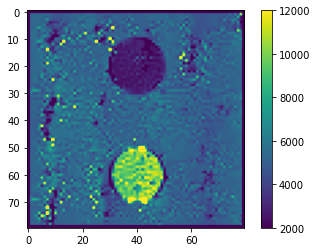

In [26]:
plt.imshow(abs(G[:,:,1]))
plt.colorbar()
plt.clim(2000,12000) 
